In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import tensorflow as tf
from keras.models import load_model
from keras import optimizers
import tensorflow.keras.backend as K
from osgeo import gdal

from matplotlib import pyplot as plt
import random
from skimage.io import imshow
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from IPython.display import clear_output
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

seed = 101

In [2]:
IMAGE_HEIGHT = IMAGE_WIDTH = 64
NUM_BANDS = 32
images_path = 'Data/BuildingsDataSet/Images/'
masks_path = 'Data/BuildingsDataSet/Masks/'

In [3]:
def load_image(image):
    return gdal.Open(image, gdal.GA_ReadOnly)
    
def convert_to_array(dataset):
    bands = [dataset.GetRasterBand(i + 1).ReadAsArray() for i in range(dataset.RasterCount)]
    return np.stack(bands, 2)

def normalize(img):
    min = img.min()
    max = img.max()
    x = 2.0 * (img - min) / (max - min) - 1.0
    return x

def normalize_(img):
    min = img.min()
    max = img.max()
    x = (img - min) / (max - min)
    return x

In [4]:
files = next(os.walk(images_path))[2]

all_images = []
all_masks = []
num_skipped = 0
for image_file in files:

    image_path = images_path + image_file
    image = load_image(image_path)
    image_data = convert_to_array(image)
    image_data[np.isnan(image_data)] = 0 # adiciona 0 onde é NaN
    image_data = normalize_(image_data)
    
    # multiplicando por 1000 para padronizar o ndvi
    #image_data[:,:,8:10] = image_data[:,:,8:10] * 1000

    mask_path = masks_path + image_file
    mask = load_image(mask_path)
    mask_data = convert_to_array(mask)
    mask_data[np.isnan(mask_data)] = 0 # adiciona 0 onde é NaN
    mask_data[mask_data>0] = 1
    mask_data[mask_data<=0] = 0
       
    # Pule qualquer mask e imagem em que a mask esteja mais de 99% vazia.
    if np.any(mask_data):
        num_white_pixels = len(mask_data[mask_data==1])
        num_black_pixels = len(mask_data[mask_data==0])
        if num_black_pixels == 0: num_black_pixels = 1 # para evitar erro de dividir por 0

        if num_white_pixels/num_black_pixels < 0.01:
            num_skipped+=1
            continue
            
        #os.rename(image_path, img_path + image_file)
        #os.rename(mask_path, mks_path + image_file)
        
        all_images.append(image_data)
        all_masks.append(mask_data)
    else: 
        num_skipped+=1
    
    """if len(all_images) >= 1:
        break
    """

images = np.array(all_images)
#images = images[:,:,:,[0,1,2,3,4,5,6,7]]
masks = np.array(all_masks, dtype=int)

print('Total imagens: \n', len(all_images))
print('Images: \n', images.shape)
print('Masks: \n', masks.shape)
print("\n{} Images were skipped.".format(num_skipped))
print("\nUnique elements in the train mask:", np.unique(masks))

Total imagens: 
 160
Images: 
 (160, 64, 64, 32)
Masks: 
 (160, 64, 64, 1)

0 Images were skipped.

Unique elements in the train mask: [0 1]


In [ ]:
plt.figure(figsize=(20,16))
x, y = 2,2
for i in range(y):  
    for j in range(x):
        plt.subplot(y*2, x, i*2*x+j+1)
        pos = i*2 + j*1
        #plt.imshow((images[pos][:,:,1:4]).astype(np.uint8))
        plt.imshow(np.clip(images[pos][:,:,[0,1,2]] / 5000, 0, 1))
        plt.title('Sat img #{}'.format(pos))
        plt.axis('off')
        plt.subplot(y*2, x, (i*2+1)*x+j+1)
           
        #We display the associated mask we just generated above with the training image
        plt.imshow(masks[pos])
        plt.title('Mask #{}'.format(pos))
        plt.axis('off')
        
plt.show()

In [270]:
#masks = np.expand_dims(masks, -1)

### Defining Custom Loss functions.

In [7]:
#Source: https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2
from keras import backend as K
def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)

    return iou

In [8]:
def dice_coef(y_true, y_pred, smooth = 1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def soft_dice_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

### Splitting data

In [9]:
train_images, test_images, train_masks, test_masks = train_test_split(images, masks, test_size=0.1, random_state=1)
del images, masks
print("TRAIN SET")
print(train_images.shape)
print(train_masks.shape)
print("TEST SET")
print(test_images.shape)
print(test_masks.shape)

TRAIN SET
(144, 64, 64, 32)
(144, 64, 64, 1)
TEST SET
(16, 64, 64, 32)
(16, 64, 64, 1)


### Display exemple image

In [10]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        #plt.axis('off')
    plt.show()

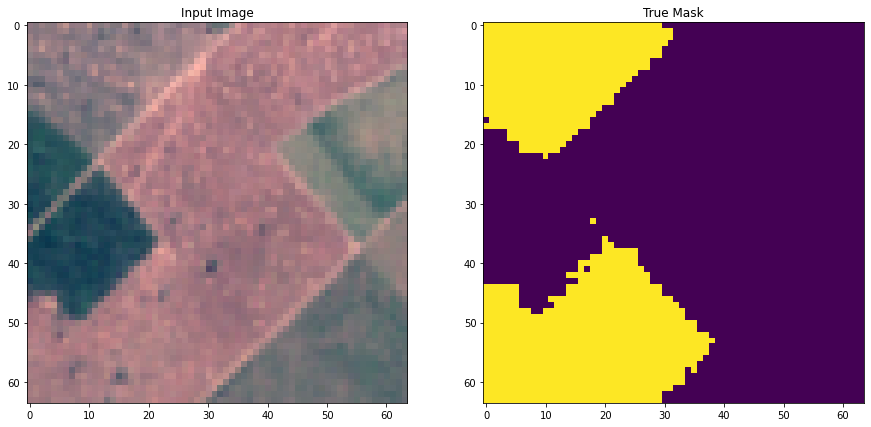

In [11]:
i = 25
sample_image, sample_mask = train_images[i], train_masks[i]
display([sample_image[:,:,[2,1,0]], sample_mask])

### Importing Our Model

In [14]:
import importlib
import import_ipynb

# para recarregar do modelo quando tiver alguma alteração
importlib.reload(M)

import unet_lstm_model as M

importing Jupyter notebook from unet_lstm_model.ipynb


In [ ]:
model = M.unet_lstm2(input_size = (IMAGE_WIDTH, IMAGE_HEIGHT, NUM_BANDS), n_filters_start=64, droprate=0.3)
model.summary()

In [ ]:
#model.load_weights('./Models/deforestation_trained_model_500_samples_many_bands_2.h5')

### Show prediction image exemple

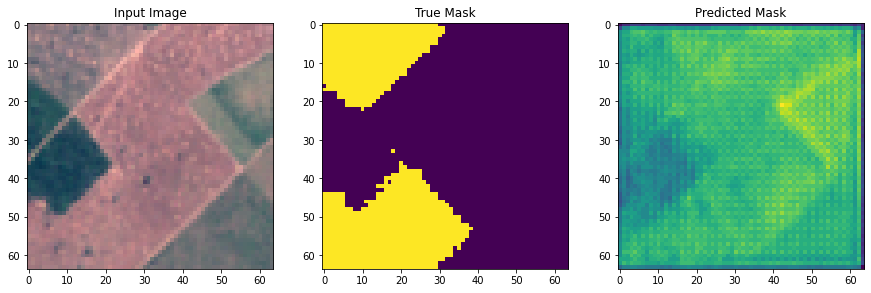

In [17]:
def show_predictions(dataset=None, num=1):
    pred_mask = model.predict(sample_image[tf.newaxis, ...])
    display([sample_image[:,:,[2,1,0]], sample_mask, pred_mask[0]])
    
show_predictions()

### Callbacks

In [18]:
model_path = "Models/checkpoint_02.h5"
checkpointer = ModelCheckpoint(model_path,
                               monitor="val_loss",
                               mode="min",
                               save_best_only = True,
                               #save_weights_only=True,
                               verbose=1
                              )

earlystopper = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0, 
                          patience = 5,
                          verbose = 1,
                          restore_best_weights = True)

lr_reducer = ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=4,
                               verbose=1,
                               mode="auto"
                              )

In [19]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

### Hyper parameters

In [22]:
EPOCHS = 30
LEARNING_RATE = 0.0001
BATCH_SIZE = 4

### Compiling the model

In [23]:
opt = optimizers.Adam(LEARNING_RATE)
model.compile(
      optimizer=opt,
      loss=soft_dice_loss,
      metrics=[iou_coef, 'acc'])

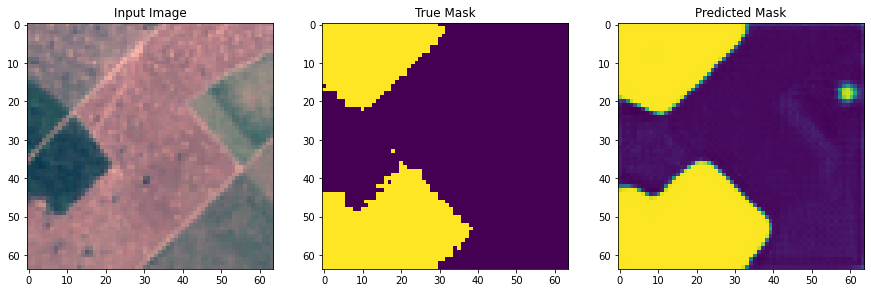


Sample Prediction after epoch 30

33/33 [==============================] - 6s 196ms/step - loss: 0.2996 - iou_coef: 0.5046 - acc: 0.9568 - val_loss: 0.2896 - val_iou_coef: 0.4865 - val_acc: 0.9484 - lr: 1.0000e-13


In [30]:
history = model.fit(train_images,
                    train_masks/1,
                    validation_split = 0.1,
                    epochs=EPOCHS,
                    batch_size = BATCH_SIZE,
                    callbacks=[checkpointer, lr_reducer, DisplayCallback()]
                  )

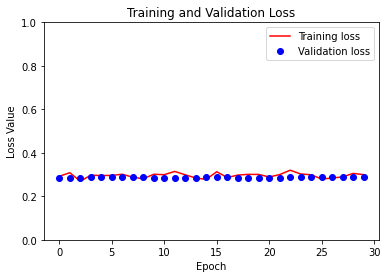

In [31]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [36]:
model.save("./Models/deforestation_trained_model_pre_imagens_whith_B5_B6.h5")

## Testing our Model

In [7]:
model = load_model("./Models/deforestation_trained_model_500_samples_many_bands.h5", custom_objects={'soft_dice_loss': soft_dice_loss, 'iou_coef': iou_coef})

In [ ]:
model.evaluate(test_images, test_masks)

In [33]:
predictions = model.predict(test_images, verbose=0)

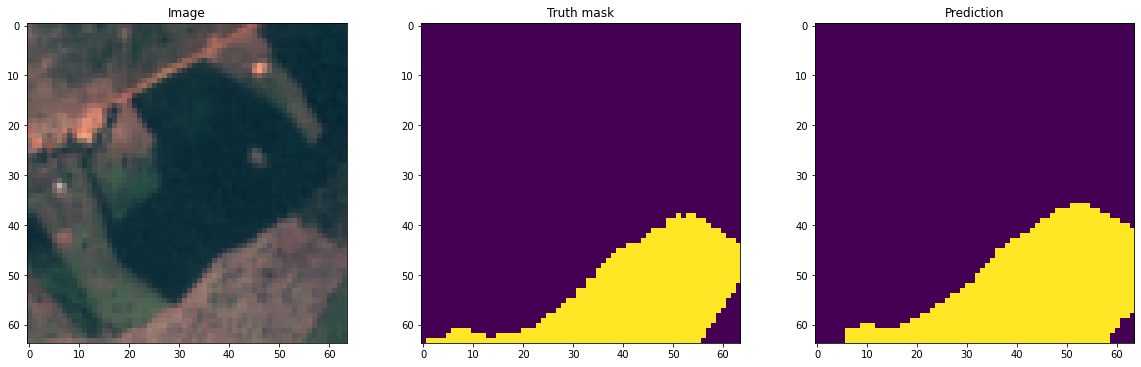

In [34]:
i = 0
p = predictions[i]
p = np.where(p > 0.5, 1, 0)

f = plt.figure(figsize=(20,20))

f.add_subplot(3, 3, 1)
# 2 = B4, 1 = B3, 0 = B2
plt.imshow(tf.keras.preprocessing.image.array_to_img(test_images[i][:,:,[2,1,0]]))
plt.title('Image')

f.add_subplot(3, 3, 2)
plt.imshow(test_masks[i])
plt.title('Truth mask')

f.add_subplot(3, 3, 3)
plt.imshow(p)
plt.title('Prediction')
       
plt.show()

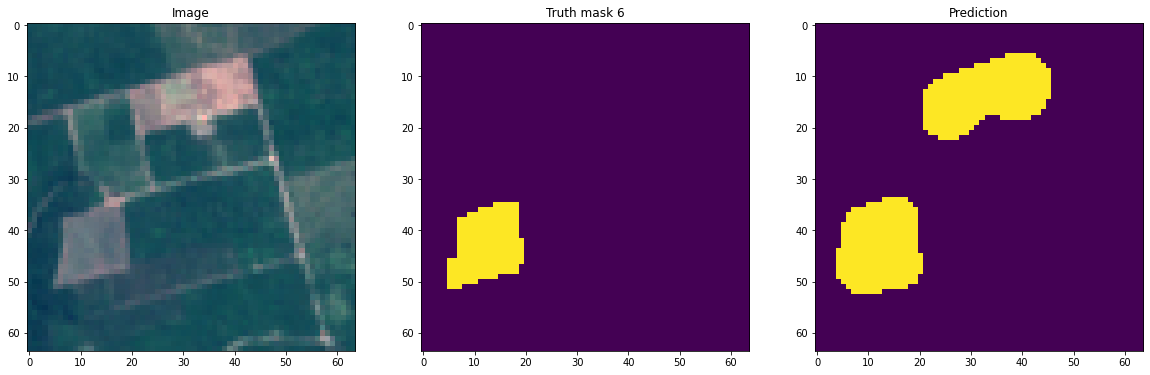

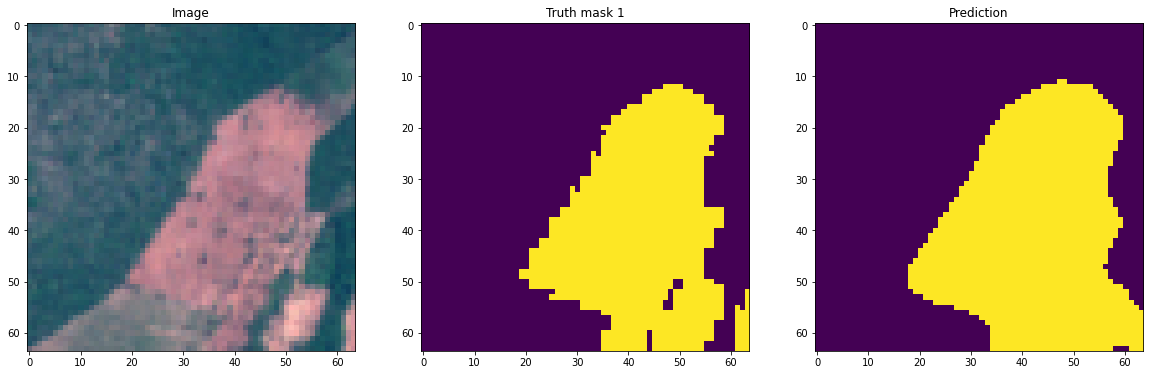

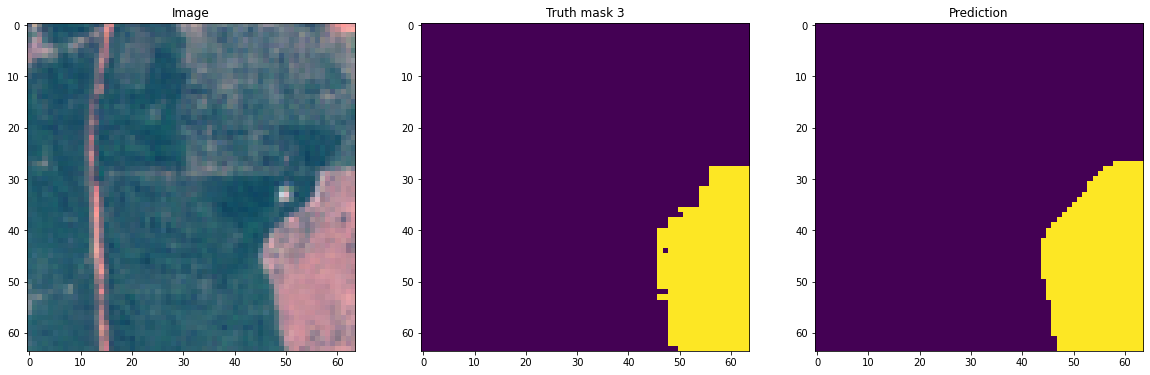

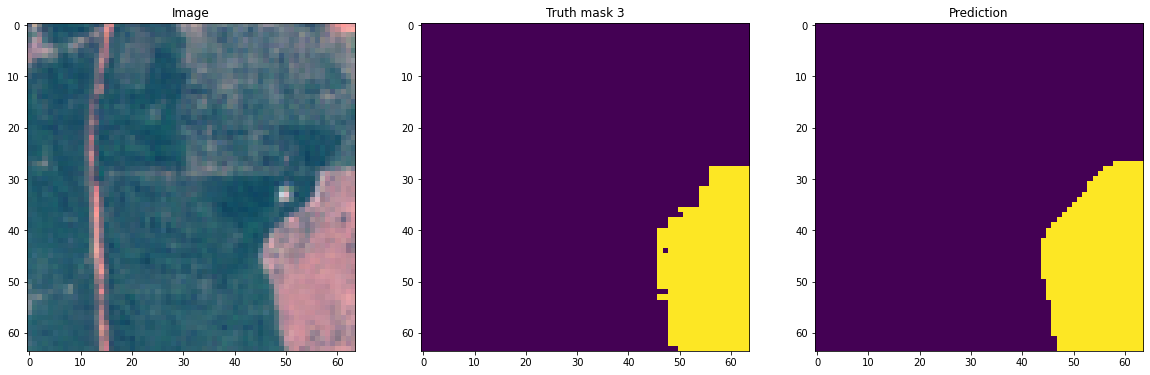

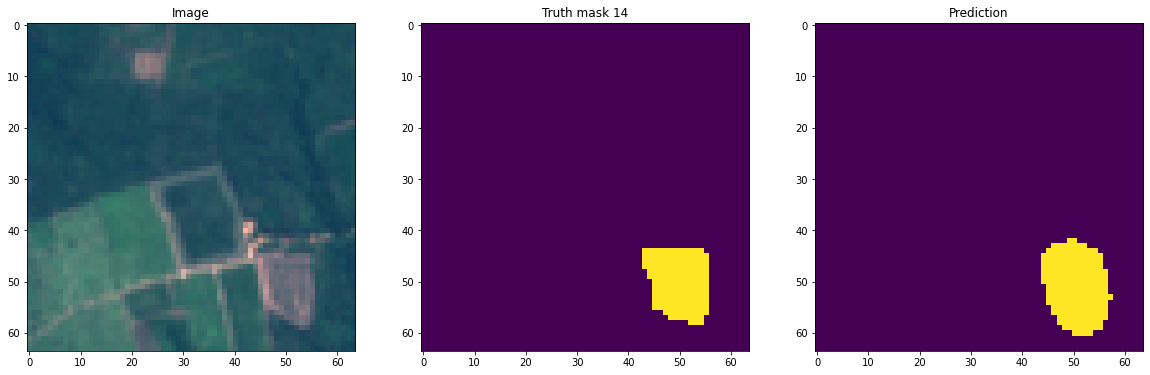

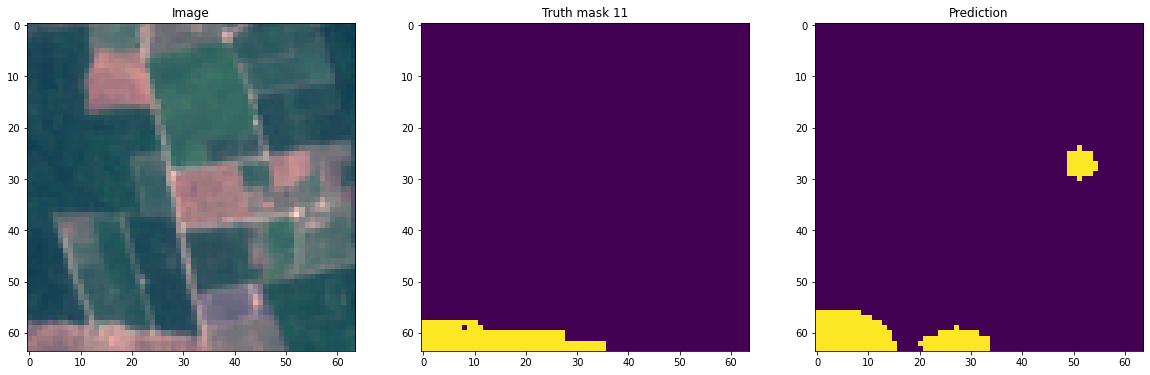

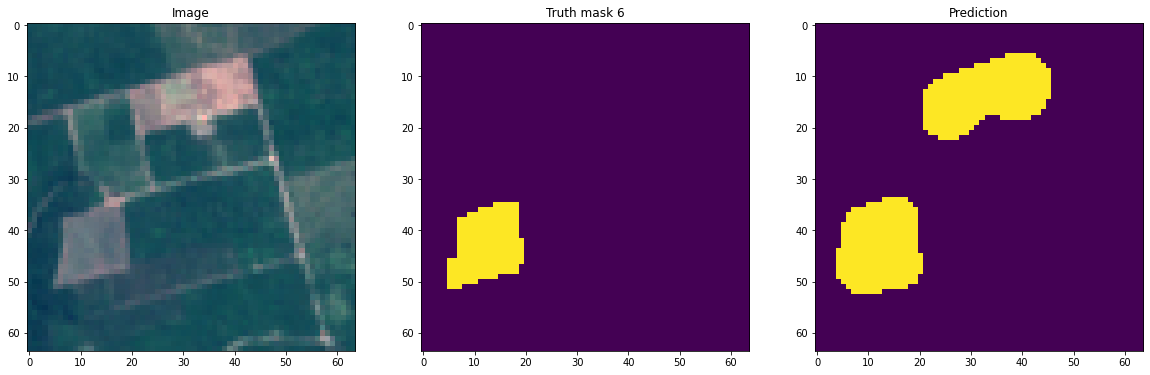

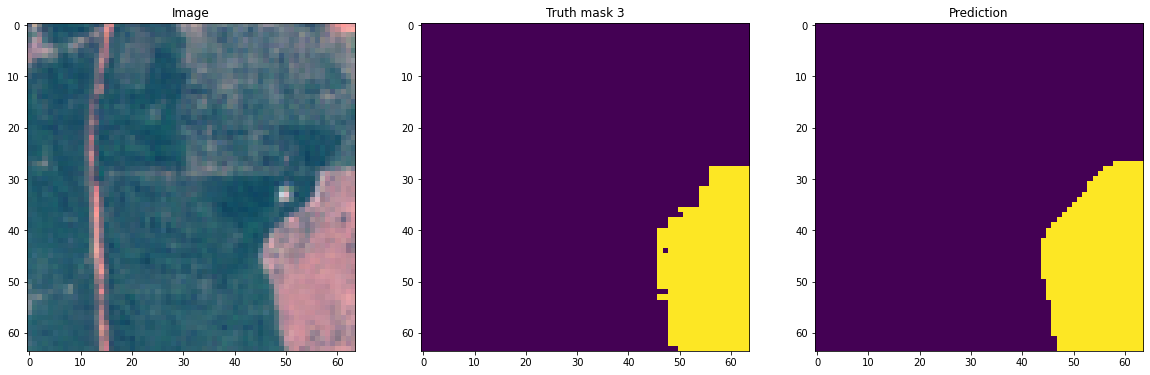

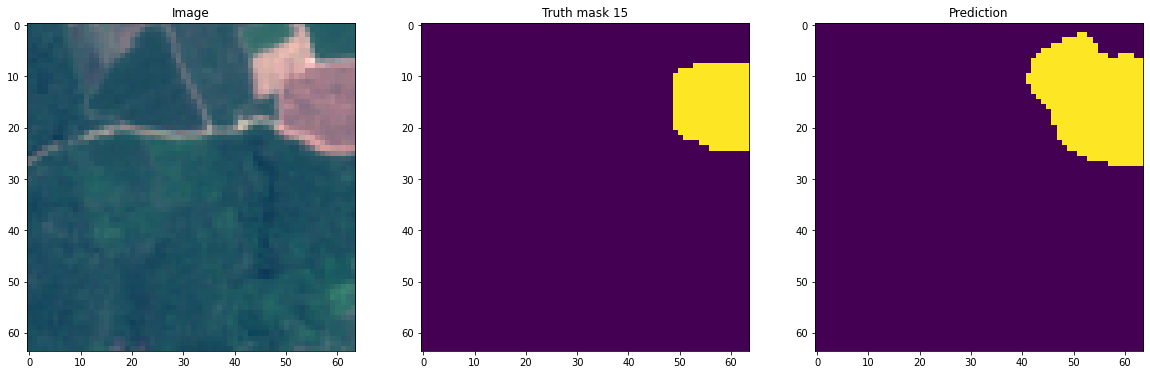

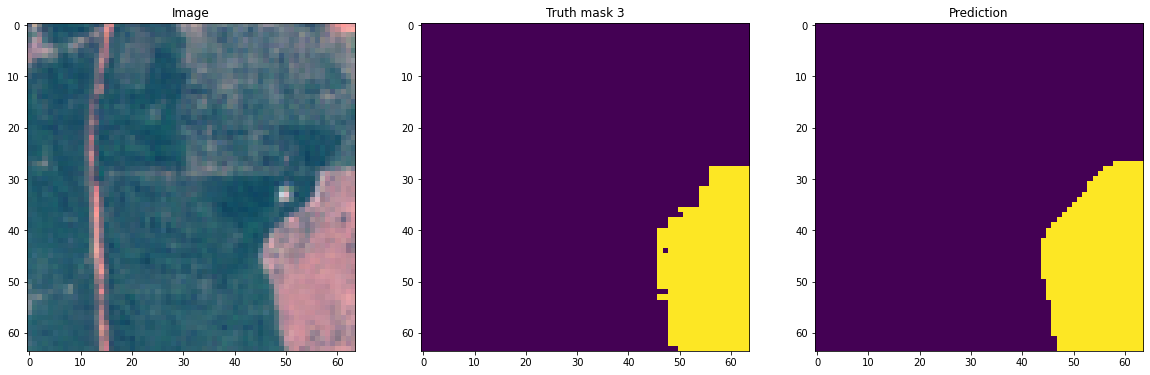

In [35]:
#ix = random.randint(0, len(predictions))
num_samples = 10

for i in range(1, num_samples*3, 3):
    ix = random.randint(0, len(predictions))
    
    f = plt.figure(figsize = (20, 150))
       
    f.add_subplot(num_samples, 3, i)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(test_images[ix][:,:,[2,1,0]]))
    plt.title("Image")
    #plt.axis('off')

    f.add_subplot(num_samples, 3, i+1)
    plt.imshow(test_masks[ix])
    plt.title("Truth mask {}".format(ix))
    #plt.axis('off')

    p = predictions[ix]
    p = np.where(p > 0.5, 1, 0)
    f.add_subplot(num_samples, 3, i+2)
    plt.imshow(p)
    plt.title("Prediction")
    #plt.axis('off')

    """f.add_subplot(num_samples, 4, i+3)
    imshow(np.squeeze(predicton_threshold[ix][:,:,0]))
    plt.title("thresholded at {}".format(thresh_val))
    plt.axis('off')
    """

plt.show()